In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import pandas as pd
import numpy as np
import psycopg2
from datetime import datetime
from datetime import date


pd.options.display.max_columns = 40

connection = psycopg2.connect('dbname = threeoneone user=threeoneoneadmin password=threeoneoneadmin')
cursor = connection.cursor()

# Hack for Heat #9: Total complaints over time, complaints per capita, etc.

In this post, I'm going to be doing a couple of miscellaneous things to prepare for our first blog post of the summer. Last year's posts can be found [here](http://heatseek.org/blog/).

In [2]:
cursor.execute('''SELECT createddate, borough, complainttype FROM service;''')
borodata = cursor.fetchall()

In [3]:
borodata = pd.DataFrame(borodata)

In [4]:
borodata.columns = ['Date', 'Boro', 'Comptype']

Again, I removed entires earlier than 2011 because there are data quality issues (substantially fewer cases):

In [5]:
borodata = borodata.loc[borodata['Date'] > date(2011,3,1)]

In [6]:
borodata = borodata.loc [borodata['Date'] <date(2016,6,1)]

Remove cases where the borough was unspecified:

In [7]:
borodata = borodata.loc[borodata['Boro'] != 'Unspecified']

## Total complaints by borough, year-over-year

We already have a chart of heat complaints by month; we need one for the total number of complaints received.

In [8]:
borodata['Year'] = [x.year for x in borodata['Date']]
borodata['Month'] = [x.month for x in borodata['Date']]
borodata['Day'] = [x.day for x in borodata['Date']]

In [9]:
plotdata = borodata.groupby(by=['Boro', 'Year', 'Month']).count()
plotdata.head()

Date  Comptype    Day
Boro  Year Month                        
BRONX 2011 3      26256     26256  26256
           4      22898     22898  22898
           5      22722     22722  22722
           6      23677     23677  23677
           7      27348     27348  27348

Now we generate a dictionary that we can use to plot these data:

In [10]:
plotdict = {x:[] for x in borodata['Boro'].unique()}

In [11]:
for boro in plotdict:
    plotdict[boro] = list(plotdata.xs(boro).Date)

Now we need to format our data for the plot. We need 5 "rows", each representing a borough, and n columns, each representing one month.

In [12]:
plotdata = np.zeros(len(plotdict['BROOKLYN']))
legendkey = []

for boro in plotdict.keys():
    plotdata = np.row_stack((plotdata, plotdict[boro]))
    legendkey.append(boro)
    
plotdata = np.delete(plotdata, (0), axis=0)

In [13]:
x = np.arange(len(plotdata[0]))

#crude xlabels
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
years = ['2011', '2012', '2013', '2014', '2015', '2016']
xlabels = []
for year in years:
    for month in months:
        xlabels.append("{0} {1}".format(month,year))

        
xlabels = xlabels[2:-7] #start from march 2011, end may2016

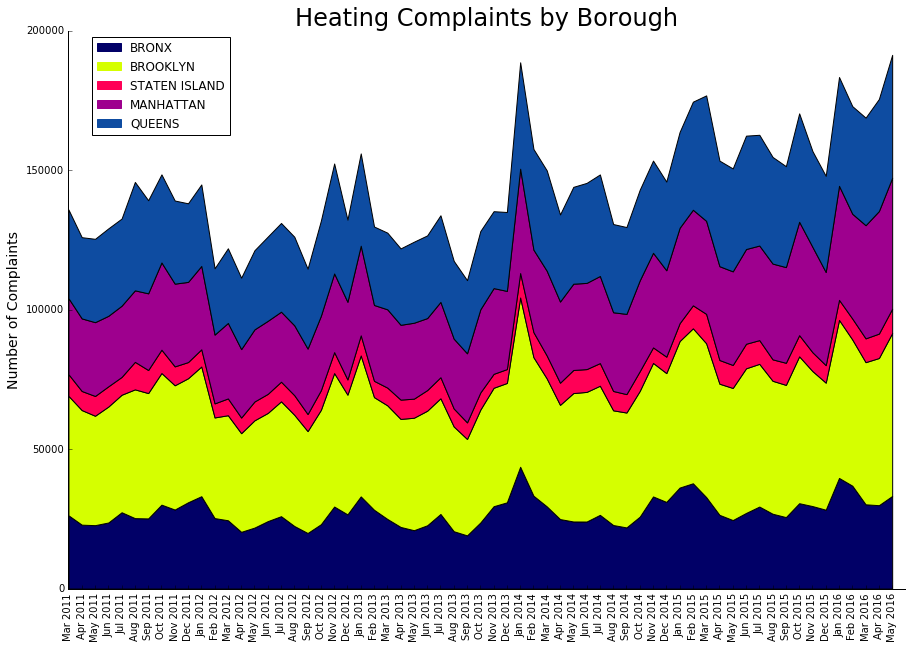

In [14]:
plotcolors = [(1,0,103),(213,255,0),(255,0,86),(158,0,142),(14,76,161),(255,229,2),(0,95,57),\
            (0,255,0),(149,0,58),(255,147,126),(164,36,0),(0,21,68),(145,208,203),(98,14,0)]

#rescaling rgb from 0-255 to 0 to 1
plotcolors = [(color[0]/float(255),color[1]/float(255),color[2]/float(255)) for color in plotcolors]
legendcolors = [mpatches.Patch(color = color) for color in plotcolors]

plt.figure(figsize = (15,10));
plt.stackplot(x,plotdata, colors = plotcolors);
plt.xticks(x,xlabels,rotation=90);
plt.xlim(0,len(xlabels))
plt.legend(legendcolors,legendkey, bbox_to_anchor=(0.2, 1));
plt.title('Heating Complaints by Borough', size = 24)
plt.ylabel('Number of Complaints',size = 14)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

In [15]:
plotdatacsv = pd.DataFrame(plotdata)
plotdatacsv.index = legendkey
plotdatacsv.columns = xlabels
plotdatacsv.to_csv('totalcomplaintsbyboroughandmonth.csv')

## Normalized total complaints

We'll also need a normalized version of the above, where everything is scaled to 100%, to see if complaints come disproportionately from one borough vs. another. There are probably better ways to do this, but I'm going to simply sum the number of complaints from each time point, and divide each column by the total for that column (i.e., number of complaints from that borough for that month divided by total number of complaints).

In [16]:
normplotdata = np.ndarray(shape=np.shape(plotdata))

It will thus be helpful to have an array of the total number of complaints:

In [17]:
totalcomplaintsbymonth = borodata.groupby(by=['Year','Month']).count().Date

In [18]:
totalcomplaintsbymonth = totalcomplaintsbymonth.values

In [19]:
totalcomplaintsbymonth = np.tile(totalcomplaintsbymonth,(5,1))

In [20]:
normplotdata = plotdata/totalcomplaintsbymonth

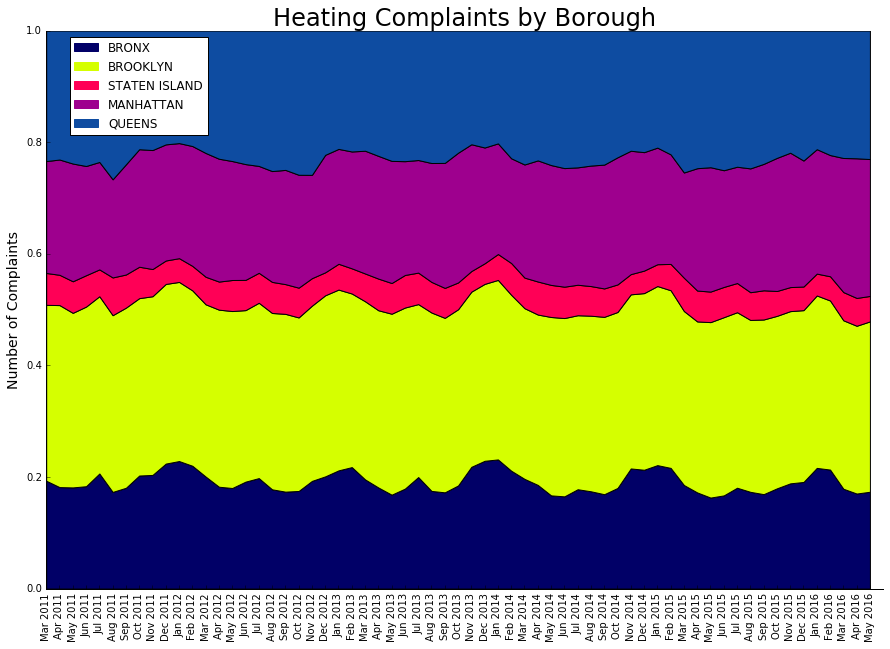

In [21]:
plotcolors = [(1,0,103),(213,255,0),(255,0,86),(158,0,142),(14,76,161),(255,229,2),(0,95,57),\
            (0,255,0),(149,0,58),(255,147,126),(164,36,0),(0,21,68),(145,208,203),(98,14,0)]

#rescaling rgb from 0-255 to 0 to 1
plotcolors = [(color[0]/float(255),color[1]/float(255),color[2]/float(255)) for color in plotcolors]
legendcolors = [mpatches.Patch(color = color) for color in plotcolors]

plt.figure(figsize = (15,10));
plt.stackplot(x,normplotdata, colors = plotcolors);
plt.xticks(x,xlabels,rotation=90);
plt.xlim(0,len(xlabels))
plt.ylim(0,1)
plt.legend(legendcolors,legendkey, bbox_to_anchor=(0.2, 1));
plt.title('Heating Complaints by Borough', size = 24)
plt.ylabel('Number of Complaints',size = 14)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

## Heat complaints per capita:

We'd also like to look at how many complaints per capita are generated. Given that we only have full years for 2012-2015, let's consider those.

In [22]:
boropop = {
    'MANHATTAN': 1636268,
    'BRONX': 1438159,
    'BROOKLYN': 2621793,
    'QUEENS': 2321580,
    'STATEN ISLAND': 473279,
    }

In [23]:
totalnycpop = reduce(lambda x, y: x +y, boropop.values())
totalnycpop

8491079

In [24]:
complaintsbyyear = borodata.groupby(by=['Year']).count()
borocomplaintsbyyear = borodata.groupby(by=['Year','Boro']).count()

In [25]:
complaintsbyyear['Pop'] = [totalnycpop for x in complaintsbyyear.index]

In [26]:
borocomplaintsbyyear['Pop'] = [boropop.get(x[1]) for x in borocomplaintsbyyear.index]

In [27]:
complaintsbyyear['CompPerCap'] = complaintsbyyear['Day']/complaintsbyyear['Pop']

In [28]:
complaintsbyyear

,Date,Boro,Comptype,Month,Day,Pop,CompPerCap
Year,,,,,,,
2011,1359368,1359368,1359368,1359368,1359368,8491079,0.160094
2012,1528597,1528597,1528597,1528597,1528597,8491079,0.180024
2013,1546188,1546188,1546188,1546188,1546188,8491079,0.182096
2014,1770357,1770357,1770357,1770357,1770357,8491079,0.208496
2015,1924917,1924917,1924917,1924917,1924917,8491079,0.226699
2016,891783,891783,891783,891783,891783,8491079,0.105026


In [29]:
borocomplaintsbyyear['CompPerCap'] = borocomplaintsbyyear['Day']/borocomplaintsbyyear['Pop']

In [30]:
borocomplaintsbyyear

Date  Comptype   Month     Day      Pop  CompPerCap
Year Boro                                                                
2011 BRONX          262597    262597  262597  262597  1438159    0.182592
     BROOKLYN       434038    434038  434038  434038  2621793    0.165550
     MANHATTAN      273282    273282  273282  273282  1636268    0.167015
     QUEENS         315070    315070  315070  315070  2321580    0.135714
     STATEN ISLAND   74381     74381   74381   74381   473279    0.157161
2012 BRONX          296502    296502  296502  296502  1438159    0.206168
     BROOKLYN       482088    482088  482088  482088  2621793    0.183877
     MANHATTAN      314437    314437  314437  314437  1636268    0.192167
     QUEENS         358990    358990  358990  358990  2321580    0.154632
     STATEN ISLAND   76580     76580   76580   76580   473279    0.161807
2013 BRONX          302328    302328  302328  302328  1438159    0.210219
     BROOKLYN       490979    490979  490979  490979  2621793    0.187268
     MANHATTAN      332487    332487  332487  332487  1636268    0.203198
     QUEENS         343772    343772  343772  343772  2321580    0.148077
     STATEN ISLAND   76622     76622   76622   76622   473279    0.161896
2014 BRONX          340297    340297  340297  340297  1438159    0.236620
     BROOKLYN       557290    557290  557290  557290  2621793    0.212561
     MANHATTAN      373895    373895  373895  373895  1636268    0.228505
     QUEENS         408389    408389  408389  408389  2321580    0.175910
     STATEN ISLAND   90486     90486   90486   90486   473279    0.191190
2015 BRONX          355017    355017  355017  355017  1438159    0.246855
     BROOKLYN       602144    602144  602144  602144  2621793    0.229669
     MANHATTAN      417223    417223  417223  417223  1636268    0.254985
     QUEENS         455115    455115  455115  455115  2321580    0.196037
     STATEN ISLAND   95418     95418   95418   95418   473279    0.201610
2016 BRONX          169773    169773  169773  169773  1438159    0.118049
     BROOKLYN       271140    271140  271140  271140  2621793    0.103418
     MANHATTAN      209840    209840  209840  209840  1636268    0.128243
     QUEENS         200335    200335  200335  200335  2321580    0.086293
     STATEN ISLAND   40695     40695   40695   40695   473279    0.085985

From these data, we can see two things: First, on average, about 1 in 5 people make a 311 complaint each year. Second, overall, this number are pretty consistent across the 5 boroughs.